In [3]:
import re
import xlwt

from bs4 import BeautifulSoup
from requests import get
from json import load, dump
from nltk.tokenize import WordPunctTokenizer
from itertools import product

wpt = WordPunctTokenizer()
URL = 'https://ru.wikipedia.org/wiki/Список_АЭС_мира'

def parse(URL):
    content = get(URL).content
    html = BeautifulSoup(content, 'lxml')

    return html

def extract_tables(html):
    tables = []

    for table in html('table',{'class':'wikitable'}):
        if 'действует' in table.text:
            tables += [table]

    return tables

def extract_reactors(tables):

    def parse_year(tr):
        src = " ".join([ td.text for td in tr('td') ]).replace('\n',' ')
        r = r'(\d{2}\.\d{4})'
        return max([ int(x.split('.')[1]) for x in re.findall(r, src) ])

    def parse_prod(tr):
        prod = tr('td')[9].text.strip()
        if re.match(r'\d+\.\d+', prod):
            prod = tr('td')[8].text.strip()

        return " ".join([ z for z in wpt.tokenize(prod) if z not in ['англ','рус'] and len(z) > 2 ])


    reactors = []
    for table in tables:
        trs = [ tr for tr in table('tr') if 'действует' in tr.text ]
        for tr in trs:
            year = parse_year(tr)
            prod = parse_prod(tr)
            reactors += [{'year':year,'prod':prod}]
    return reactors

def create_graphics(reactors):
    rez = {}
    for reactor in reactors:
        year = reactor['year']//10*10
        prod = reactor['prod']
        try:
            rez[f"{year}, {prod}"] += 1
        except KeyError:
            rez.update({f"{year}, {prod}":1})


    wb = xlwt.Workbook(encoding = 'UTF-8')
    ws = wb.add_sheet("Result")
    years = sorted({ (x['year']//10*10) for x in reactors })
    prods = sorted({ x['prod'] for x in reactors })
    for i, year in enumerate(years, start=1): ws.write(0, i, year)
    for j, prod in enumerate(prods, start=1): ws.write(j, 0, prod)
    for (i, year), (j, prod) in product(
            enumerate(years, start=1), 
            enumerate(prods, start=1)):
        try:
            v = rez[f"{year}, {prod}"]
        except KeyError:
            v = 0
        ws.write(j, i, v)
    
    wb.save('out.xls')


    dump(fp=open('tmp/out.json','w'), obj=rez, indent=2, ensure_ascii=0)

if __name__ == '__main__':
    html = parse(URL)
    tables = extract_tables(html)
    reactors = extract_reactors(tables)
    create_graphics(reactors)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df = pd.read_excel('out.xls', index_col=0)

df.index = pd.Categorical(df.index)

df

,1960,1970,1980,1990,2000,2010,2020
ABB Atom,0,0,4,0,0,0,0
AECL,0,0,1,1,3,0,0
AECL DHIC,0,0,0,3,0,0,0
ASEA Atom Stal Laval,0,1,1,0,0,0,0
Areva,0,0,0,0,0,2,0
Atomic Energy Can,0,6,9,4,0,0,0
Atomic Energy Canada,0,1,1,0,0,0,0
CNNC,0,0,0,1,2,2,0
Canadian Gen Elec,0,1,0,0,0,0,0
China FHI,0,0,0,0,0,8,0


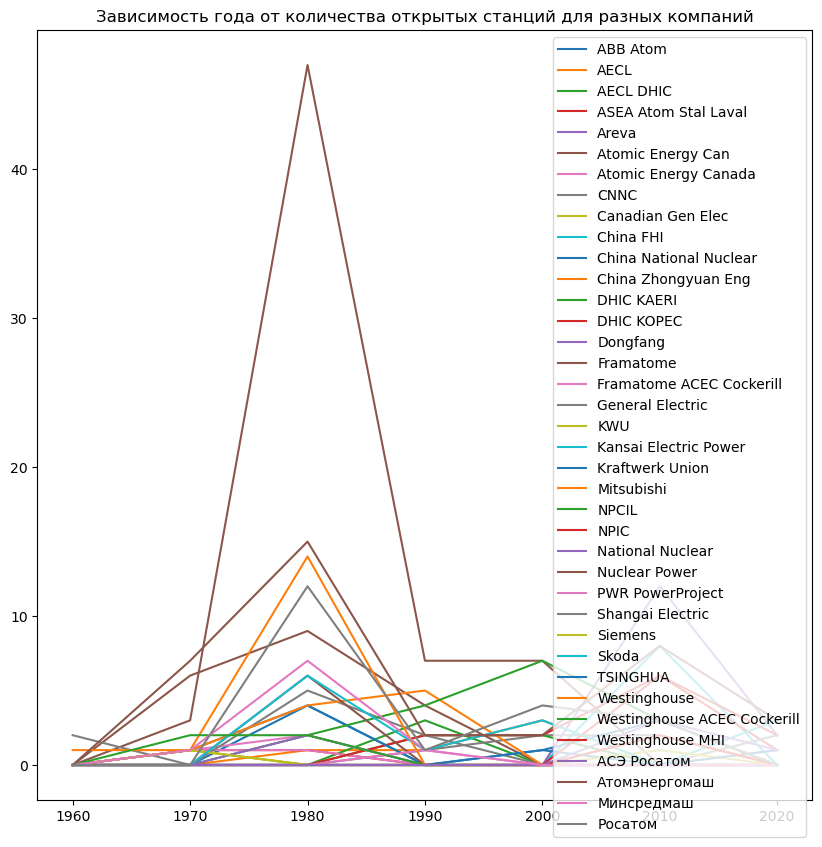

In [45]:
plt.rcParams['figure.figsize'] = (10, 10)

plt.title('Зависимость года от количества открытых станций для разных компаний')

for com in df.T:
    plt.plot(df.columns, df.T[com], label=com)

plt.legend()